In [1]:
import csv
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
import sys
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import time
import numpy as np
from pprint import pprint

import spacy  # For preprocessing
import nltk
import string
from nltk.corpus import stopwords
import preprocessor as p  #pip install tweet-preprocessor
import logging  # Setting up the loggings to monitor gensim
from nltk.stem import WordNetLemmatizer
from string import punctuation as punc

import gensim
import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.models as gsm
from gensim.test.utils import datapath

import regex
# import emoji #pip install emoji --upgrade
# Internal dependencies
# import word_emoji2vec as we2v
#from word_emoji2vec import Word_Emoji2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
# import torchvision.transforms as transforms
from torch.autograd import Variable

####BERT

from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [2]:
!nvidia-smi

Fri Sep 24 10:58:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 38%   54C    P8    21W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:67:00.0 Off |                  N/A |
| 46%   65C    P8    17W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import torch
# torch.cuda.empty_cache() 
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    #device = torch.device("cuda") # select the zeroth GPU with this line: gpu = 0
    #device = torch.cuda.set_device(1)  #wrong provide device = None  
    device = torch.device(1) #(use cuda device 1) for gpu = 1
    torch.cuda.set_device(device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name())

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [4]:
net_emb = gsm.KeyedVectors.load_word2vec_format('user.emd')

INFO:gensim.models.utils_any2vec:loading projection weights from user.emd
INFO:gensim.models.utils_any2vec:loaded (728, 300) matrix from user.emd


In [5]:
###### text preprocessing #########

def remove_string_noise(input_str):
    input_str = re.sub(r"http\S+", "", input_str)
    punctuation_noise ="!\"$%&'#()*+,-./:;<=>?@[\]^_`{|}~" #print string.punctuation 
    special_noise = ""

    all_noise = punctuation_noise + special_noise

    for c in all_noise:
        if c in input_str:
            input_str = input_str.replace(c, " ")#replace with space
    fresh_str = ' '.join(input_str.split())
    return fresh_str

def clean_tweets(tweet):
    wordnet_lemmatizer = WordNetLemmatizer()
    sw = set(stopwords.words('english'))
    operators = set(('no', 'not', 'nor', 'none'))
    stop_words = set(sw) - operators
    stop_words.update([ 'amp', 'rt'])  ###as we are using set so we used .update....otherwise .extends
    
    word_tokens = nltk.word_tokenize(tweet)
    filtered_tweet = []
    for w in word_tokens:
        #if w not in stop_words and w not in emoticons:
        if w not in stop_words:
            filtered_tweet.append(w)
    lemmatized_tweet = []
    for word in filtered_tweet:
        lemmatized_tweet.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    return ' '.join(lemmatized_tweet)
    
def pre_processing_tweets (df):    
    clean_text = []

    for i in df:
        clean_text.append(p.clean(str(i)))#python 3
    fresh_text1 = []
    for i in range (0, df.shape[0]):
        fresh_text1.append(remove_string_noise(clean_text[i]))
    
    filtered_tweet = []
    for i in range (0, len(fresh_text1)):
        filtered_tweet.append(clean_tweets(fresh_text1[i].lower()))
    
    return filtered_tweet

In [6]:
import pandas as pd

train_net = pd.read_csv('train_net.csv')
test_net = pd.read_csv('test_net.csv')
valid_net = pd.read_csv('valid_net.csv')

In [7]:
train_net

,username,label_x,label_y,name_num
0,CharmaineMillot,0,0,979
1,FormerRepVet,1,1,590
2,michellesawyer6,0,0,530
3,tuoba_denrael,0,0,980
4,seasttotheworld,1,1,602
...,...,...,...,...
1255,ActivistHat_,0,0,236
1256,BethEckenrod,1,1,95
1257,AddictedTaU,1,1,1771
1258,JeffreyaMeier,1,1,1772


In [8]:
import pandas as pd

train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [9]:
train = train[train['label']!=2]
test = test[test['label']!=2]

In [10]:
train_tweet = train[['tweet','username','label']]
test_tweet = test[['tweet','username','label']]

In [11]:
train_tweet = train[['tweet','username','label']].groupby(['username','label'])['tweet'].apply(list).reset_index(name='text')
test_tweet = test[['tweet','username','label']].groupby(['username','label'])['tweet'].apply(list).reset_index(name='text')

In [12]:
train_tweet = train_tweet.reset_index()
test_tweet = test_tweet.reset_index()

In [13]:
train_tweet_net = pd.merge(train_net, train_tweet, on="username")

In [14]:
valid_tweet_net = pd.merge(valid_net, train_tweet, on="username")
test_tweet_net = pd.merge(test_net, test_tweet, on="username")

In [15]:
print(len(train_tweet_net))
print(len(valid_tweet_net))
print(len(test_tweet_net))

1260
315
396


In [16]:
df = pd.read_csv('./datasets/total_obj_users.csv')

In [17]:
train_tweet_net_obj = pd.merge(train_tweet_net, df, on="username")
valid_tweet_net_obj = pd.merge(valid_tweet_net, df, on="username")
test_tweet_net_obj = pd.merge(test_tweet_net, df, on="username")

In [18]:
print(len(train_tweet_net_obj))
print(len(valid_tweet_net_obj))
print(len(test_tweet_net_obj))

1260
315
396


In [19]:
import pandas as pd

train = pd.read_csv('./datasets/train_user.csv')
test = pd.read_csv('./datasets/test_user.csv')

In [20]:
df = pd.concat([train,test])
df = df[df['label']!=2]

In [21]:
train_tweet_net_obj_des = pd.merge(train_tweet_net_obj, df, on="username")
valid_tweet_net_obj_des = pd.merge(valid_tweet_net_obj, df, on="username")
test_tweet_net_obj_des = pd.merge(test_tweet_net_obj, df, on="username")

In [22]:
train_tweet_net_obj_des.head(1)

,username,label_x,label_y,name_num,index,label_x,text,obj,label_y,description,follower_count,creation_date,following_count,label
0,CharmaineMillot,0,0,979,165,0,[Quite worthy of a retweet!!! https://t.co/a7s...,NAN,0,I am a human rights defender working to expose...,665,2011-09-02 20:31:46,1296,0


In [23]:
print(len(train_tweet_net_obj_des))
print(len(valid_tweet_net_obj_des))
print(len(test_tweet_net_obj_des))

1259
315
396


In [24]:
sentences_train_twt = pre_processing_tweets(train_tweet_net_obj_des.text)
sentences_valid_twt = pre_processing_tweets(valid_tweet_net_obj_des.text)
sentences_test_twt = pre_processing_tweets(test_tweet_net_obj_des.text)

In [25]:
sentences_train_des = pre_processing_tweets(train_tweet_net_obj_des.description)
sentences_valid_des = pre_processing_tweets(valid_tweet_net_obj_des.description)
sentences_test_des = pre_processing_tweets(test_tweet_net_obj_des.description)

In [26]:
sentences_train_obj = pre_processing_tweets(train_tweet_net_obj_des.obj)
sentences_valid_obj = pre_processing_tweets(valid_tweet_net_obj_des.obj)
sentences_test_obj = pre_processing_tweets(test_tweet_net_obj_des.obj)

In [27]:
sentences_train_twt = np.array(sentences_train_twt)
sentences_train_des = np.array(sentences_train_des)
sentences_train_obj = np.array(sentences_train_obj)
labels_train = train_tweet_net_obj_des.label.values

sentences_valid_twt = np.array(sentences_valid_twt)
sentences_valid_des = np.array(sentences_valid_des)
sentences_valid_obj = np.array(sentences_valid_obj)
labels_valid = valid_tweet_net_obj_des.label.values

sentences_test_twt = np.array(sentences_test_twt)
sentences_test_des = np.array(sentences_test_des)
sentences_test_obj = np.array(sentences_test_obj)
labels_test = test_tweet_net_obj_des.label.values

In [28]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [29]:
def token_id(sentences):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = bert_tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 128,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            truncation=True, #explicitely truncate examples to max length. #my add
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [30]:
input_ids_train_des, attention_masks_train_des = token_id(sentences_train_des )
input_ids_valid_des, attention_masks_valid_des = token_id(sentences_valid_des )
input_ids_test_des, attention_masks_test_des = token_id(sentences_test_des)

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [31]:
input_ids_train_obj, attention_masks_train_obj = token_id(sentences_train_obj )
input_ids_valid_obj, attention_masks_valid_obj = token_id(sentences_valid_obj )
input_ids_test_obj, attention_masks_test_obj = token_id(sentences_test_obj)

In [32]:
from transformers import LongformerModel, LongformerTokenizer, LongformerConfig
longformer_tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096', do_lower_case=True)

In [33]:
def token_id_twt(sentences):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = longformer_tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 4000,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            truncation=True, #explicitely truncate examples to max length. #my add
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        #print(type(input_ids[0]), input_ids[0], input_ids[0].size())
        #sys.exit()

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [34]:
input_ids_train_twt, attention_masks_train_twt = token_id_twt(sentences_train_twt)
input_ids_valid_twt, attention_masks_valid_twt = token_id_twt(sentences_valid_twt )
input_ids_test_twt, attention_masks_test_twt = token_id_twt(sentences_test_twt)

In [35]:
def nn_input_network(train_data):
    training_data =[]
    for i in range (0, len(train_data)):
        for j in range (0,train_data.shape[0]):
            label =  [int(train_data.label[j])]
            if(str(train_data['name_num'][i]) not in net_emb ):
                net_emb[str(train_data['name_num'][i])] = np.zeros(300)
            net_emb_tensor = torch.Tensor(net_emb[str(train_data['name_num'][i])])
            training_data.append(net_emb_tensor.unsqueeze(0))
            break
    return training_data

In [36]:
training_data_net =  nn_input_network(train_tweet_net_obj_des)
validation_data_net =  nn_input_network(valid_tweet_net_obj_des)
testing_data_net =  nn_input_network(test_tweet_net_obj_des)

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  


In [37]:
training_data_net = torch.cat(training_data_net, dim=0)
validation_data_net = torch.cat(validation_data_net, dim=0)
testing_data_net = torch.cat(testing_data_net, dim=0)

In [38]:
labels_train = torch.tensor(labels_train)
labels_valid = torch.tensor(labels_valid)
labels_test = torch.tensor(labels_test)

In [39]:
from torch.utils.data import TensorDataset, random_split
#print
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train_des, input_ids_train_obj, training_data_net, input_ids_train_twt, labels_train)
val_dataset = TensorDataset(input_ids_valid_des, input_ids_valid_obj, validation_data_net, input_ids_valid_twt, labels_valid)
test_dataset = TensorDataset(input_ids_test_des, input_ids_test_obj, testing_data_net, input_ids_test_twt, labels_test)

In [40]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [41]:
from transformers import BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
long_roberta = LongformerModel.from_pretrained('allenai/longformer-base-4096', gradient_checkpointing=True)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
from torchnlp.nn import Attention #pip imstall pytorch-nlp
class ROBERTALSTMSentiment(nn.Module):
    def __init__(self,
                 long_roberta,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.long_roberta = long_roberta
        
        embedding_dim = long_roberta.config.to_dict()['hidden_size'] #768
              
        self.rnn = nn.LSTM(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        
        
        self.dropout = nn.Dropout(dropout)
        self.attn_fc = Attention(hidden_dim * 2 if bidirectional else hidden_dim) #attention layer from torchnlp
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, text):     
        with torch.no_grad():
            embedded = self.long_roberta(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        #print("embedded", type(embedded), embedded.size()) #torch.Size([32, 50, 768])
        #embedded = self.dropout(embedded) #add dropout...don't use it...dropout layer after an pre-trained embedding, that the weights are not learnt during training
        lstm_out, (hidden, c_n) = self.rnn(embedded) #for lstm
        
        #hidden = [n layers * n directions, batch size, hid dim]
        #print("hidden before", type(hidden), hidden.size()) #torch.Size([4, 32, 256])
        if self.rnn.bidirectional: #add dropout
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
#         if self.rnn.bidirectional: #No dropout
#             hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
#         else:
#             hidden = hidden[-1,:,:]
            
        #lstm_out = self.dropout(lstm_out) #add dropout
    
        #hidden = [batch size, hid dim]
        #print("hidden after", type(hidden), hidden.size()) #torch.Size([32, 512]) cz of bi-direction = 2 * 256 = 512
        #attn_out = self.attention(lstm_out, hidden)
#         query = hidden = [batch size, output length, dimensions]
#         context = lstm_out = [batch size, query length, dimensions]
#        input for attention attention(query, context)
#       output for attention tuple with output and weights
        attn_out = self.attn_fc(hidden.unsqueeze(1), lstm_out)
        #print(type(attn_out[0]), attn_out[0].size(), type(attn_out[1]), attn_out[1].size()) #output = torch.Size([32, 1, 512]), weight = torch.Size([32, 1, 160])
        #print("attn_out", attn_out.size())
        #output = self.out(hidden)
        
        #output = self.out(attn_out[0].squeeze(1)) #only tweet
        #return output
        return attn_out[0].squeeze(1)

In [44]:
class BERTLSTMSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size'] #768
              
        self.rnn = nn.LSTM(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        
        
        self.dropout = nn.Dropout(dropout)
        self.attn_fc = Attention(hidden_dim * 2 if bidirectional else hidden_dim) #attention layer from torchnlp
    
    def attention(self, rnn_out, state):
        state = state.unsqueeze(2)
        weights = torch.bmm(rnn_out, state)
        weights = F.log_softmax(weights.squeeze(2),dim = 1).unsqueeze(2)
        return torch.bmm(torch.transpose(rnn_out, 1, 2), weights).squeeze(2)

    
    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
            
        lstm_out, (hidden, c_n) = self.rnn(embedded) #for lstm
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return hidden

In [45]:
class NetworkMLP(nn.Module):
    def __init__(self):
        super(NetworkMLP, self).__init__() 
        self.fc1 = nn.Linear(300, 150)
        
    def forward(self, X):
        z1 = self.fc1(X)
        return z1 

In [46]:
class JointModel(nn.Module):
    def __init__(self,
                 bert,long_roberta,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        super().__init__()
        self.model_des = BERTLSTMSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)
        self.model_loc = BERTLSTMSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)
        self.model_net = NetworkMLP()
        self.model_twt = ROBERTALSTMSentiment(long_roberta,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)
        self.fc1 = nn.Linear((hidden_dim * 6 +150) if bidirectional else (hidden_dim * 3 +150), 600)
        self.fc2 = nn.Linear(600, output_dim) #original
        self.dropout = nn.Dropout(dropout)
    def forward(self, x_d, x_l, x_n, x_t): 
        prediction_des = self.model_des(x_d)
        prediction_loc = self.model_loc(x_l)
        prediction_net = self.model_net(x_n)
        prediction_twt = self.model_twt(x_t)
        concat_pred = torch.cat((prediction_des, prediction_loc, prediction_net, prediction_twt), 1) #concat with dim= 1
        output = self.fc1(concat_pred)
        output = self.dropout(output) # add dropout
        output = self.fc2(F.relu(output)) #original

        return output

In [47]:
HIDDEN_DIM = 300 #good
OUTPUT_DIM = 3
N_LAYERS = 2 #original good
#N_LAYERS = 3
BIDIRECTIONAL = True
#DROPOUT = 0.25 #original
DROPOUT = 0.3 #good

model = JointModel(bert, long_roberta, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL,DROPOUT)

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 276,799,452 trainable parameters


In [49]:
for name, param in model.named_parameters():    
    #print(name)
    if name.startswith('bert') or name.startswith('long_roberta'):
        param.requires_grad = False

In [50]:
# import torch.optim as optim

# optimizer = optim.Adam(model.parameters())

In [51]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [52]:
criterion = nn.CrossEntropyLoss()

In [53]:
model = model.to(device) 
criterion = criterion.to(device) 

In [54]:
def f1_accuracy(preds, y):
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    
    from sklearn.metrics import f1_score
    macro_f1 = f1_score(y.to("cpu"), preds.to("cpu"), average='macro')

    return acc, macro_f1

In [55]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_macro = 0
    model.train()
    for step, batch in enumerate(iterator):    

        optimizer.zero_grad()
        des = batch[0].to(device)
        loc = batch[1].to(device)
        net = batch[2].to(device)
        twt = batch[3].to(device)
        label = batch[4].to(device)
        predictions = model(des, loc, net, twt)

        loss = criterion(predictions, label)
        acc, macro_f1 = f1_accuracy(torch.argmax(predictions, dim = 1), label)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_macro += macro_f1.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_macro / len(iterator)

In [56]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_macro = 0
    model.eval()
    
    with torch.no_grad():
        for step, batch in enumerate(iterator):    
            des = batch[0].to(device)
            loc = batch[1].to(device)
            net = batch[2].to(device)
            twt = batch[3].to(device)
            label = batch[4].to(device)

            predictions = model(des, loc, net, twt)
            loss = criterion(predictions, label)
            acc, macro_f1 = f1_accuracy(torch.argmax(predictions, dim = 1), label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_macro += macro_f1.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_macro / len(iterator)

In [57]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')
per_epoch_train_loss = []
per_epoch_val_loss = []
per_epoch_train_f1 = []
per_epoch_val_f1 = []
per_epoch_train_acc = []
per_epoch_val_acc = []
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, validation_dataloader, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    per_epoch_train_loss.append(train_loss)
    per_epoch_val_loss.append(valid_loss)
    per_epoch_train_f1.append(train_f1)
    per_epoch_val_f1.append(valid_f1)
    per_epoch_train_acc.append(train_acc)
    per_epoch_val_acc.append(valid_acc)
    
    if valid_loss <= best_valid_loss:
        best_valid_loss = valid_loss
        print("best model saved in epoch :", epoch+1 )
    torch.save(model.state_dict(), 'data/stance_model/stance_model_'+str(epoch+1)+'.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f} | Train macro-avg-f1: {train_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f} |  Val. macro-avg-f1: {valid_f1*100:.2f}%')

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

best model saved in epoch : 1
Epoch: 01 | Epoch Time: 6m 15s
	Train Loss: 0.739 | Train Acc: 52.08 | Train macro-avg-f1: 42.78%
	 Val. Loss: 0.645 |  Val. Acc: 70.42 |  Val. macro-avg-f1: 63.23%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

best model saved in epoch : 2
Epoch: 02 | Epoch Time: 7m 47s
	Train Loss: 0.582 | Train Acc: 68.96 | Train macro-avg-f1: 63.72%
	 Val. Loss: 0.502 |  Val. Acc: 75.42 |  Val. macro-avg-f1: 71.09%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

best model saved in epoch : 3
Epoch: 03 | Epoch Time: 6m 33s
	Train Loss: 0.487 | Train Acc: 77.00 | Train macro-avg-f1: 74.00%
	 Val. Loss: 0.437 |  Val. Acc: 81.25 |  Val. macro-avg-f1: 78.97%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

Epoch: 04 | Epoch Time: 6m 13s
	Train Loss: 0.437 | Train Acc: 81.20 | Train macro-avg-f1: 78.47%
	 Val. Loss: 0.444 |  Val. Acc: 78.85 |  Val. macro-avg-f1: 76.78%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

Epoch: 05 | Epoch Time: 6m 45s
	Train Loss: 0.430 | Train Acc: 81.38 | Train macro-avg-f1: 78.67%
	 Val. Loss: 0.457 |  Val. Acc: 77.71 |  Val. macro-avg-f1: 75.69%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

best model saved in epoch : 6
Epoch: 06 | Epoch Time: 7m 43s
	Train Loss: 0.422 | Train Acc: 82.04 | Train macro-avg-f1: 79.95%
	 Val. Loss: 0.408 |  Val. Acc: 80.42 |  Val. macro-avg-f1: 78.09%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

Epoch: 07 | Epoch Time: 7m 30s
	Train Loss: 0.378 | Train Acc: 83.33 | Train macro-avg-f1: 80.49%
	 Val. Loss: 0.414 |  Val. Acc: 81.15 |  Val. macro-avg-f1: 78.80%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

best model saved in epoch : 8
Epoch: 08 | Epoch Time: 6m 30s
	Train Loss: 0.358 | Train Acc: 84.97 | Train macro-avg-f1: 83.17%
	 Val. Loss: 0.400 |  Val. Acc: 82.50 |  Val. macro-avg-f1: 80.23%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

Epoch: 09 | Epoch Time: 6m 11s
	Train Loss: 0.350 | Train Acc: 85.31 | Train macro-avg-f1: 83.96%
	 Val. Loss: 0.413 |  Val. Acc: 81.04 |  Val. macro-avg-f1: 78.96%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

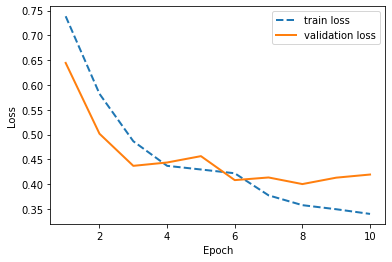

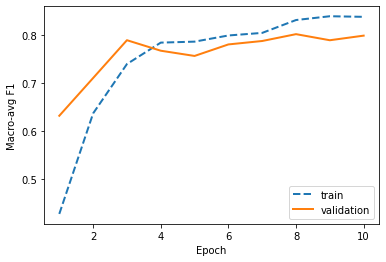

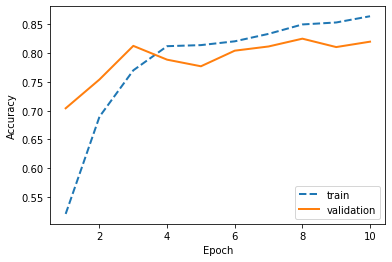

In [63]:
def save_plots(train_losses, val_losses, train_f1, val_f1, train_accs, val_accs):
    """Plot

        Plot two figures: loss vs. epoch and accuracy vs. epoch
    """
    n = len(train_losses)
    xs = np.arange(1,n+1,1)

    # plot train and val losses
    fig, ax = plt.subplots()
    ax.plot(xs, train_losses, '--', linewidth=2, label='train loss')
    ax.plot(xs, val_losses, '-', linewidth=2, label='validation loss')
    #ax.set_xlim(0, 10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc='upper right')

    # plot train and val f1-score
    #plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_f1, '--', linewidth=2, label='train')
    ax.plot(xs, val_f1, '-', linewidth=2, label='validation')
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Macro-avg F1")
    ax.legend(loc='lower right')
    
    # plot train and val accuracy
    #plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_accs, '--', linewidth=2, label='train')
    ax.plot(xs, val_accs, '-', linewidth=2, label='validation')
    #ax.set_xlim(0, 10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend(loc='lower right')
    
save_plots(per_epoch_train_loss, per_epoch_val_loss, per_epoch_train_f1, per_epoch_val_f1, per_epoch_train_acc, per_epoch_val_acc)

In [64]:
def evaluate_test(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_macro = 0
    model.eval()
    
    with torch.no_grad():
        preds , true_labels = [], []
        for step, batch in enumerate(iterator):    
            des = batch[0].to(device)
            loc = batch[1].to(device)
            net = batch[2].to(device)
            twt = batch[3].to(device)
            label = batch[4].to(device)

            predictions = model(des, loc, net, twt)
            loss = criterion(predictions, label)
            acc, macro_f1 = f1_accuracy(torch.argmax(predictions, dim = 1), label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_macro += macro_f1.item()
            
            preds.append(torch.argmax(predictions, dim = 1).to('cpu').numpy())
            true_labels.append(label.to('cpu').numpy())
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_macro / len(iterator), preds, true_labels

In [65]:
# For Test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [66]:
from sklearn.metrics import classification_report

for epoch in range(0,10):
#     model = JointModel(bert, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL,DROPOUT)
#     model = model.to(device)
    model.load_state_dict(torch.load('data/stance_model/stance_model_'+str(epoch+1)+'.pt')) 
    test_loss, test_acc, test_f1, pred, label = evaluate_test(model, test_dataloader, criterion)

    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.3f} | Test macro-avg-f1: {test_f1*100:.3f}%')
    flat_predictions = np.concatenate(pred, axis=0)
    flat_labels = np.concatenate(label, axis=0)
    
    print(classification_report(flat_labels, flat_predictions, digits=4))

Test Loss: 0.645 | Test Acc: 67.250 | Test macro-avg-f1: 62.873%
              precision    recall  f1-score   support

           0     0.6203    0.9196    0.7409       199
           1     0.8416    0.4315    0.5705       197

    accuracy                         0.6768       396
   macro avg     0.7310    0.6755    0.6557       396
weighted avg     0.7304    0.6768    0.6561       396

Test Loss: 0.530 | Test Acc: 73.750 | Test macro-avg-f1: 71.285%
              precision    recall  f1-score   support

           0     0.6942    0.8442    0.7619       199
           1     0.7987    0.6244    0.7009       197

    accuracy                         0.7348       396
   macro avg     0.7465    0.7343    0.7314       396
weighted avg     0.7462    0.7348    0.7315       396

Test Loss: 0.444 | Test Acc: 80.750 | Test macro-avg-f1: 77.991%
              precision    recall  f1-score   support

           0     0.7617    0.8995    0.8249       199
           1     0.8758    0.7157    0.787